# 多量子比特系统可扩展性实验

## 实验概述

本实验专注于多量子比特系统的可扩展性分析，验证物理信息神经网络(PINN)在不同量子比特数下的性能表现。

In [1]:
# 导入必要的库
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.linalg import sqrtm
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import pandas as pd
from tqdm import tqdm
import warnings

warnings.filterwarnings('ignore')

# 设置随机种子确保可重复性
np.random.seed(42)
torch.manual_seed(42)

# 设置matplotlib样式
plt.style.use('default')
sns.set_palette("husl")

print("环境配置完成！")

环境配置完成！


In [2]:
class MultiQubitQuantumTools:
    """多量子比特系统工具类"""
    
    @staticmethod
    def random_pure_state(n_qubits):
        """生成随机纯态"""
        dim = 2**n_qubits
        state = np.random.randn(dim) + 1j * np.random.randn(dim)
        return state / np.linalg.norm(state)
    
    @staticmethod
    def random_mixed_state(n_qubits, purity=0.8):
        """生成随机混合态"""
        dim = 2**n_qubits
        # 生成随机纯态
        psi = MultiQubitQuantumTools.random_pure_state(n_qubits)
        rho = np.outer(psi, psi.conj())
        
        # 添加噪声以创建混合态
        identity = np.eye(dim, dtype=complex)
        rho_mixed = purity * rho + (1 - purity) * identity / dim
        return rho_mixed / np.trace(rho_mixed)
    
    @staticmethod
    def GHZ_state(n_qubits):
        """生成GHZ态"""
        dim = 2**n_qubits
        state = np.zeros(dim, dtype=complex)
        state[0] = 1/np.sqrt(2)
        state[-1] = 1/np.sqrt(2)
        return np.outer(state, state.conj())
    
    @staticmethod
    def W_state(n_qubits):
        """生成W态（适用于2和3量子比特）"""
        if n_qubits == 2:
            # 对于2量子比特，使用Bell态之一作为类似W态
            state = np.array([0, 1/np.sqrt(2), 1/np.sqrt(2), 0], dtype=complex)
        elif n_qubits == 3:
            # 标准3量子比特W态
            state = np.array([0, 1/np.sqrt(3), 1/np.sqrt(3), 0, 1/np.sqrt(3), 0, 0, 0], dtype=complex)
        else:
            # 对于更高量子比特数，生成一个简单的W-like态
            state = np.zeros(2**n_qubits, dtype=complex)
            for i in range(n_qubits):
                idx = 2**i  # 二进制表示中只有一个1的位置
                state[idx] = 1/np.sqrt(n_qubits)
        return np.outer(state, state.conj())
    
    @staticmethod
    def pauli_operators():
        """返回单量子比特Pauli算符"""
        I = np.array([[1, 0], [0, 1]], dtype=complex)
        X = np.array([[0, 1], [1, 0]], dtype=complex)
        Y = np.array([[0, -1j], [1j, 0]], dtype=complex)
        Z = np.array([[1, 0], [0, -1]], dtype=complex)
        return [I, X, Y, Z]
    
    @staticmethod
    def multiqubit_pauli_matrices(n_qubits):
        """生成多量子比特Pauli测量算符"""
        paulis = MultiQubitQuantumTools.pauli_operators()
        
        if n_qubits == 1:
            return paulis
        
        # 多量子比特情况：张量积
        multi_paulis = []
        for ops in np.ndindex((4,) * n_qubits):
            op = paulis[ops[0]]
            for i in range(1, n_qubits):
                op = np.kron(op, paulis[ops[i]])
            multi_paulis.append(op)
        
        return multi_paulis
    
    @staticmethod
    def simulate_measurements(rho, n_measurements=1000, noise_level=0.01):
        """模拟具有shot noise和系统噪声的量子测量过程"""
        n_qubits = int(np.log2(rho.shape[0]))
        paulis = MultiQubitQuantumTools.multiqubit_pauli_matrices(n_qubits)
        
        frequencies = []
        for pauli in paulis:
            # 计算期望值并转为测量概率
            expectation = np.real(np.trace(rho @ pauli))
            prob = np.clip((expectation + 1) / 2, 0, 1)
            
            # Shot noise：对每个测量设置随机的shot数
            jitter = max(1, int(n_measurements * 0.2))
            shots = max(10, int(n_measurements + np.random.randint(-jitter, jitter + 1)))
            shot_freq = np.random.binomial(shots, prob) / shots
            
            # 系统噪声：附加高斯噪声
            noisy_freq = shot_freq + np.random.normal(0, noise_level)
            noisy_freq = np.clip(noisy_freq, 0, 1)
            frequencies.append(noisy_freq)
        
        return np.array(frequencies)
    
    @staticmethod
    def fidelity(rho1, rho2):
        """计算量子态保真度"""
        # 确保输入是numpy数组
        if hasattr(rho1, 'cpu'):
            rho1 = rho1.cpu().numpy()
        if hasattr(rho2, 'cpu'):
            rho2 = rho2.cpu().numpy()
        
        sqrt_rho1 = sqrtm(rho1)
        fidelity_matrix = sqrtm(sqrt_rho1 @ rho2 @ sqrt_rho1)
        return np.real(np.trace(fidelity_matrix))**2
    
    @staticmethod
    def constraint_violation(rho):
        """计算物理约束违反程度"""
        # 确保输入是numpy数组
        if hasattr(rho, 'cpu'):
            rho = rho.cpu().numpy()
        
        # 厄米性违反
        hermiticity = np.linalg.norm(rho - rho.conj().T)
        
        # 迹归一化违反
        trace_violation = abs(np.trace(rho) - 1)
        
        # 正定性违反 (最小特征值)
        eigenvals = np.linalg.eigvals(rho)
        positivity_violation = max(0, -np.real(eigenvals).min())
        
        return hermiticity + trace_violation + positivity_violation
    
    @staticmethod
    def cholesky_to_density_matrix(alpha, n_qubits):
        """从Cholesky参数构造密度矩阵"""
        dim = 2**n_qubits
        n_params = dim * (dim + 1) // 2
        
        # 确保alpha是numpy数组
        if hasattr(alpha, 'cpu'):
            alpha = alpha.detach().cpu().numpy()
        alpha = np.array(alpha, dtype=np.float64).flatten()
        
        if alpha.size < 2 * n_params:
            alpha = np.pad(alpha, (0, 2 * n_params - alpha.size), mode='constant')
        
        # 根据参数还原下三角矩阵
        L = np.zeros((dim, dim), dtype=complex)
        idx = 0
        for i in range(dim):
            for j in range(i+1):
                if i == j:
                    L[i, j] = abs(alpha[idx]) + 1e-9  # 对角元需为正
                    idx += 1
                else:
                    L[i, j] = alpha[idx] + 1j * alpha[idx + 1]
                    idx += 2
        
        rho = L @ L.conj().T
        rho = rho / np.trace(rho)
        return rho
    
    @staticmethod
    def density_to_cholesky_params(rho):
        """将密度矩阵转换为Cholesky参数向量"""
        if hasattr(rho, 'cpu'):
            rho = rho.detach().cpu().numpy()
        rho = np.array(rho, dtype=complex)
        rho = (rho + rho.conj().T) / 2  # 保证厄米
        dim = rho.shape[0]
        identity = np.eye(dim, dtype=complex)
        jitter = 1e-10
        for _ in range(6):
            try:
                L = np.linalg.cholesky(rho + jitter * identity)
                break
            except np.linalg.LinAlgError:
                jitter *= 10
        else:
            eigvals, eigvecs = np.linalg.eigh(rho)
            eigvals = np.clip(eigvals, 0, None)
            rho = eigvecs @ np.diag(eigvals) @ eigvecs.conj().T + jitter * identity
            L = np.linalg.cholesky(rho)
        L = np.tril(L)
        params = []
        for i in range(dim):
            for j in range(i+1):
                if i == j:
                    params.append(max(L[i, j].real, 1e-9))
                else:
                    params.append(L[i, j].real)
                    params.append(L[i, j].imag)
        return np.array(params, dtype=np.float32)
    
    @staticmethod
    def params_to_density_no_constraint(alpha, n_qubits):
        """不施加Cholesky约束的直接参数->密度矩阵映射"""
        # 这个方法在多量子比特情况下更加复杂，此处简化实现
        if hasattr(alpha, 'cpu'):
            alpha = alpha.detach().cpu().numpy()
        alpha = np.array(alpha, dtype=np.float64).flatten()
        
        # 根据量子比特数确定矩阵维度
        dim = 2**n_qubits
        rho = np.zeros((dim, dim), dtype=complex)
        idx = 0
        for i in range(dim):
            for j in range(dim):
                if idx < len(alpha) - 1:
                    rho[i, j] = alpha[idx] + 1j * alpha[idx + 1]
                    idx += 2
        
        trace = np.trace(rho)
        if abs(trace) < 1e-9:
            trace = 1e-9
        rho = rho / trace
        return rho

In [3]:
class MultiQubitDataset(Dataset):
    """多量子比特量子态层析数据集"""
    
    STATE_TYPES = ['GHZ', 'W', 'RandomPure', 'RandomMixed']
    
    def __init__(self, n_qubits=2, n_samples=1000, n_measurements=1000, noise_level=0.01):
        self.qt = MultiQubitQuantumTools()
        self.n_qubits = n_qubits
        
        print(f"生成 {n_samples} 个 {n_qubits} 量子比特量子态的数据集...")
        
        self.measurements = []
        self.true_states = []
        self.target_params = []
        self.state_types = []
        
        for i in tqdm(range(n_samples)):
            # 生成不同类型的量子态
            state_idx = i % 4
            state_type = self.STATE_TYPES[state_idx]
            if state_idx == 0:
                # GHZ态
                rho = self.qt.GHZ_state(n_qubits)
            elif state_idx == 1:
                # W态
                rho = self.qt.W_state(n_qubits)
            elif state_idx == 2:
                # 随机纯态
                psi = self.qt.random_pure_state(n_qubits)
                rho = np.outer(psi, psi.conj())
            else:
                # 随机混合态
                rho = self.qt.random_mixed_state(n_qubits)
            
            # 模拟测量
            freq = self.qt.simulate_measurements(rho, n_measurements, noise_level)
            
            self.measurements.append(freq)
            self.true_states.append(rho)
            self.state_types.append(state_type)
            
            # 真实Cholesky参数作为监督信号
            target_params = self.qt.density_to_cholesky_params(rho)
            self.target_params.append(target_params)
        
        self.measurements = np.array(self.measurements)
        self.true_states = np.array(self.true_states)
        self.target_params = np.array(self.target_params)
        self.state_types = np.array(self.state_types)
        
        print(f"数据集生成完成！")
        print(f"  测量数据形状: {self.measurements.shape}")
        print(f"  真实状态形状: {self.true_states.shape}")
        print(f"  目标参数形状: {self.target_params.shape}")
        print(f"  状态类型示例: {np.unique(self.state_types)}")
    
    def __len__(self):
        return len(self.measurements)
    
    def __getitem__(self, idx):
        return {
            'measurements': torch.FloatTensor(self.measurements[idx]),
            'true_state': self.true_states[idx],  # 保持为numpy数组
            'target_params': torch.FloatTensor(self.target_params[idx]),  # Cholesky参数
            'state_type': self.state_types[idx]
        }

In [4]:
class MultiQubitPINN(nn.Module):
    """多量子比特物理信息神经网络（改进版：完全可微分）"""
    
    def __init__(self, n_qubits, input_dim, hidden_dims=[128, 64], output_dim=None):
        super().__init__()
        
        self.n_qubits = n_qubits
        dim = 2**n_qubits
        self.dim = dim
        self.output_dim = dim * (dim + 1) // 2 * 2 if output_dim is None else output_dim
        
        # 网络架构
        layers = []
        prev_dim = input_dim
        
        for hidden_dim in hidden_dims:
            layers.extend([
                nn.Linear(prev_dim, hidden_dim),
                nn.ReLU(),
                nn.Dropout(0.1)
            ])
            prev_dim = hidden_dim
        
        layers.append(nn.Linear(prev_dim, self.output_dim))
        
        self.network = nn.Sequential(*layers)
        
        # 物理约束参数 - 使用固定权重，不学习
        # 根据量子比特数自适应调整权重
        base_weight = 0.01  # 降低基础权重，避免压制MSE损失
        normalized_weight = base_weight / (dim ** 0.5)
        self.register_buffer('physics_weight', torch.tensor(normalized_weight))
        
        # 用于评估的旧方法（保持兼容性）
        self.qt = MultiQubitQuantumTools()
    
    def forward(self, x):
        return self.network(x)
    
    def cholesky_to_density_torch(self, alpha):
        """从Cholesky参数构造密度矩阵（PyTorch版本，保持梯度）"""
        batch_size = alpha.shape[0]
        dim = self.dim
        
        # 按照原始实现的格式解析参数
        # 对角元素：1个实数，非对角元素：2个实数（实部和虚部）
        n_triangular = dim * (dim + 1) // 2
        # 实际使用的参数数量：dim^2（但alpha可能有更多参数）
        n_params_used = dim * dim
        
        # 构建下三角矩阵L
        L_real = torch.zeros(batch_size, dim, dim, device=alpha.device, dtype=alpha.dtype)
        L_imag = torch.zeros(batch_size, dim, dim, device=alpha.device, dtype=alpha.dtype)
        
        idx = 0
        for i in range(dim):
            for j in range(i + 1):
                if idx >= n_params_used:
                    break
                if i == j:
                    # 对角元素：实数，需要为正
                    L_real[:, i, j] = torch.abs(alpha[:, idx]) + 1e-9
                    idx += 1
                else:
                    # 非对角元素：复数（实部和虚部）
                    if idx + 1 < alpha.shape[1]:
                        L_real[:, i, j] = alpha[:, idx]
                        L_imag[:, i, j] = alpha[:, idx + 1]
                        idx += 2
                    else:
                        break
        
        # 计算 rho = L @ L^dagger
        # L^dagger = L_real^T - 1j * L_imag^T
        L_real_T = L_real.transpose(-2, -1)
        L_imag_T = L_imag.transpose(-2, -1)
        
        # rho = L @ L^dagger = (L_real + 1j*L_imag) @ (L_real^T - 1j*L_imag^T)
        # 实部: L_real @ L_real_T + L_imag @ L_imag_T
        # 虚部: L_real @ L_imag_T - L_imag @ L_real_T
        rho_real = torch.bmm(L_real, L_real_T) + torch.bmm(L_imag, L_imag_T)
        rho_imag = torch.bmm(L_real, L_imag_T) - torch.bmm(L_imag, L_real_T)
        
        # 归一化：确保迹为1
        trace = torch.sum(rho_real[:, torch.arange(dim), torch.arange(dim)], dim=1, keepdim=True)
        trace = trace.unsqueeze(-1)  # [batch, 1, 1]
        rho_real = rho_real / (trace + 1e-9)
        rho_imag = rho_imag / (trace + 1e-9)
        
        return rho_real, rho_imag
    
    def compute_physics_loss_torch(self, rho_real, rho_imag):
        """计算物理约束损失（PyTorch版本，保持梯度）"""
        dim = self.dim
        batch_size = rho_real.shape[0]
        
        # 1. 厄米性违反：rho - rho^dagger 应该为0
        # rho^dagger 的实部 = rho_real^T, 虚部 = -rho_imag^T
        rho_real_T = rho_real.transpose(-2, -1)
        rho_imag_T = rho_imag.transpose(-2, -1)
        hermiticity_real = rho_real - rho_real_T
        hermiticity_imag = rho_imag + rho_imag_T  # 注意虚部的符号
        hermiticity_loss = torch.mean(hermiticity_real**2 + hermiticity_imag**2)
        
        # 2. 迹归一化违反：trace(rho) - 1 应该为0
        trace = torch.sum(rho_real[:, torch.arange(dim), torch.arange(dim)], dim=1)
        trace_violation = torch.mean((trace - 1.0)**2)
        
        # 3. 正定性违反：所有特征值应该 >= 0
        # 使用Gershgorin圆盘定理的近似，或者直接计算特征值
        # 为了可微分，我们使用：如果rho是正定的，则 rho + epsilon*I 的特征值都 > 0
        # 简化：使用 det(rho) >= 0 和 trace(rho) >= 0 作为近似
        # 更简单的方法：使用 rho 的最小对角元素作为正定性的近似
        diag_elements = rho_real[:, torch.arange(dim), torch.arange(dim)]
        min_diag = torch.min(diag_elements, dim=1)[0]
        positivity_loss = torch.mean(torch.clamp(-min_diag, min=0.0)**2)
        
        # 归一化损失
        normalization = dim ** 0.5
        total_loss = (hermiticity_loss + trace_violation + positivity_loss) / normalization
        
        return total_loss
    
    def predict_density_matrix(self, params):
        """从网络输出预测密度矩阵（用于评估，保持兼容性）"""
        if torch.is_tensor(params):
            alpha = params.detach().cpu().numpy()
        else:
            alpha = np.array(params)
        
        # 批量处理
        rhos = []
        for a in alpha:
            rho = self.qt.cholesky_to_density_matrix(a, self.n_qubits)
            rhos.append(rho)
        
        return np.array(rhos)
    
    def physics_loss(self, rho_pred):
        """计算物理约束损失（用于评估，保持兼容性）"""
        losses = []
        dim = 2**self.n_qubits
        for rho in rho_pred:
            cv = self.qt.constraint_violation(rho)
            normalized_cv = cv / (dim ** 0.5)
            losses.append(normalized_cv)
        return np.mean(losses)

In [5]:
class MultiQubitTrainer:
    """多量子比特模型训练器"""
    
    def __init__(self, model, device='cpu'):
        self.model = model.to(device)
        self.device = device
        self.qt = MultiQubitQuantumTools()
        
        # 确定量子比特数量
        n_qubits = 2  # 默认为2量子比特
        if hasattr(model, "n_qubits"):
            n_qubits = model.n_qubits
        
        # 优化器和损失函数
        self.optimizer = optim.Adam(model.parameters(), lr=0.001)
        self.mse_loss = nn.MSELoss()
        
        # 训练历史
        self.train_losses = []
        self.val_losses = []
        self.constraint_violations = []
    
    def train_epoch(self, train_loader):
        """训练一个epoch"""
        self.model.train()
        epoch_loss = 0
        
        for batch in train_loader:
            measurements = batch['measurements'].to(self.device)
            target_params = batch['target_params'].to(self.device)
            
            self.optimizer.zero_grad()
            
            # 前向传播
            pred = self.model(measurements)
            
            # 计算损失：预测Cholesky参数与真实参数的MSE
            loss = self.mse_loss(pred, target_params)
            
            # 对于PINN，添加物理约束损失（使用可微分版本）
            if isinstance(self.model, MultiQubitPINN):
                # 使用PyTorch版本，保持梯度
                rho_real, rho_imag = self.model.cholesky_to_density_torch(pred)
                physics_loss = self.model.compute_physics_loss_torch(rho_real, rho_imag)
                
                # 使用固定权重（不学习）
                loss = loss + self.model.physics_weight * physics_loss
            
            # 反向传播
            loss.backward()
            self.optimizer.step()
            
            epoch_loss += loss.item()
        
        return epoch_loss / len(train_loader)
    
    def validate(self, val_loader):
        """验证模型"""
        self.model.eval()
        val_loss = 0
        constraint_violations = []
        
        with torch.no_grad():
            for batch in val_loader:
                measurements = batch['measurements'].to(self.device)
                target_params = batch['target_params'].to(self.device)
                
                pred = self.model(measurements)
                
                # 计算参数预测损失
                loss = self.mse_loss(pred, target_params)
                val_loss += loss.item()
                
                # 计算约束违反
                if isinstance(self.model, MultiQubitPINN):
                    rho_pred = self.model.predict_density_matrix(pred)
                    for rho in rho_pred:
                        cv = self.qt.constraint_violation(rho)
                        constraint_violations.append(cv)
        
        avg_cv = np.mean(constraint_violations) if constraint_violations else 0
        return val_loss / len(val_loader), avg_cv
    
    def train(self, train_loader, val_loader, epochs=50):
        """完整的训练过程"""
        print(f"开始训练 {type(self.model).__name__}...")
        
        for epoch in tqdm(range(epochs)):
            train_loss = self.train_epoch(train_loader)
            val_loss, cv = self.validate(val_loader)
            
            self.train_losses.append(train_loss)
            self.val_losses.append(val_loss)
            self.constraint_violations.append(cv)
            
            if (epoch + 1) % 10 == 0:
                print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, "
                      f"Val Loss: {val_loss:.4f}, CV: {cv:.6f}")
        
        return {
            'train_losses': self.train_losses,
            'val_losses': self.val_losses,
            'constraint_violations': self.constraint_violations
        }

In [6]:
# === 改进版 PINN 与训练器（覆盖上方定义，用于高维量子态） ===
class MultiQubitPINN(nn.Module):
    """多量子比特物理信息神经网络（强化表达 + 稳定物理约束）"""
    
    def __init__(self, n_qubits, input_dim, hidden_dims=None, output_dim=None, dropout=0.1):
        super().__init__()
        if hidden_dims is None:
            hidden_dims = [512, 512, 256, 128]
        
        self.n_qubits = n_qubits
        dim = 2**n_qubits
        self.dim = dim
        self.output_dim = dim * (dim + 1) // 2 * 2 if output_dim is None else output_dim
        
        layers = []
        prev_dim = input_dim
        for hidden_dim in hidden_dims:
            layers.extend([
                nn.Linear(prev_dim, hidden_dim),
                nn.LayerNorm(hidden_dim),
                nn.SiLU(),
                nn.Dropout(dropout)
            ])
            prev_dim = hidden_dim
        layers.append(nn.Linear(prev_dim, self.output_dim))
        self.network = nn.Sequential(*layers)
        
        base_weight = 2e-4
        normalized_weight = base_weight / (dim ** 1.5)
        self.register_buffer('physics_weight', torch.tensor(normalized_weight, dtype=torch.float32))
        self.qt = MultiQubitQuantumTools()
    
    def forward(self, x):
        return self.network(x)
    
    def cholesky_to_density_torch(self, alpha):
        batch_size = alpha.shape[0]
        dim = self.dim
        n_params_used = dim * dim
        L_real = torch.zeros(batch_size, dim, dim, device=alpha.device, dtype=alpha.dtype)
        L_imag = torch.zeros(batch_size, dim, dim, device=alpha.device, dtype=alpha.dtype)
        idx = 0
        for i in range(dim):
            for j in range(i + 1):
                if idx >= n_params_used:
                    break
                if i == j:
                    L_real[:, i, j] = torch.abs(alpha[:, idx]) + 1e-9
                    idx += 1
                else:
                    if idx + 1 < alpha.shape[1]:
                        L_real[:, i, j] = alpha[:, idx]
                        L_imag[:, i, j] = alpha[:, idx + 1]
                        idx += 2
                    else:
                        break
        L_real_T = L_real.transpose(-2, -1)
        L_imag_T = L_imag.transpose(-2, -1)
        rho_real = torch.bmm(L_real, L_real_T) + torch.bmm(L_imag, L_imag_T)
        rho_imag = torch.bmm(L_real, L_imag_T) - torch.bmm(L_imag, L_real_T)
        trace = torch.sum(rho_real[:, torch.arange(dim), torch.arange(dim)], dim=1, keepdim=True)
        trace = trace.unsqueeze(-1)
        rho_real = rho_real / (trace + 1e-9)
        rho_imag = rho_imag / (trace + 1e-9)
        return rho_real, rho_imag
    
    def compute_physics_loss_torch(self, rho_real, rho_imag):
        dim = self.dim
        rho_real_T = rho_real.transpose(-2, -1)
        rho_imag_T = rho_imag.transpose(-2, -1)
        hermiticity_real = rho_real - rho_real_T
        hermiticity_imag = rho_imag + rho_imag_T
        hermiticity_loss = torch.mean(hermiticity_real**2 + hermiticity_imag**2) / (dim ** 2)
        trace = torch.sum(rho_real[:, torch.arange(dim), torch.arange(dim)], dim=1)
        trace_violation = torch.mean((trace - 1.0)**2) / dim
        rho_complex = torch.complex(rho_real, rho_imag)
        eigvals = torch.linalg.eigvalsh(rho_complex)
        positivity_loss = torch.mean(torch.clamp(-eigvals, min=0.0)**2) / dim
        return hermiticity_loss + trace_violation + positivity_loss
    
    def predict_density_matrix(self, params):
        if torch.is_tensor(params):
            alpha = params.detach().cpu().numpy()
        else:
            alpha = np.array(params)
        rhos = []
        for a in alpha:
            rho = self.qt.cholesky_to_density_matrix(a, self.n_qubits)
            rhos.append(rho)
        return np.array(rhos)
    
    def physics_loss(self, rho_pred):
        losses = []
        dim = 2**self.n_qubits
        for rho in rho_pred:
            cv = self.qt.constraint_violation(rho)
            normalized_cv = cv / (dim ** 1.5)
            losses.append(normalized_cv)
        return np.mean(losses)


class MultiQubitTrainer:
    """多量子比特模型训练器（带学习率调度、梯度裁剪、物理损失warmup）"""
    
    def __init__(self, model, device='cpu', config=None):
        self.model = model.to(device)
        self.device = device
        self.qt = MultiQubitQuantumTools()
        self.config = config or {}
        self.current_epoch = 0
        self.learning_rates = []
        
        self.n_qubits = getattr(model, 'n_qubits', self.config.get('n_qubits', 2))
        base_lr = 5e-4 if (self.n_qubits >= 4 and isinstance(model, MultiQubitPINN)) else 1e-3
        lr = self.config.get('lr', base_lr)
        betas = self.config.get('betas', (0.9, 0.999))
        weight_decay = self.config.get('weight_decay', 0.0)
        
        self.optimizer = optim.Adam(model.parameters(), lr=lr, betas=betas, weight_decay=weight_decay)
        if self.config.get('use_scheduler', True):
            self.scheduler = optim.lr_scheduler.ReduceLROnPlateau(
                self.optimizer,
                mode='min',
                factor=self.config.get('lr_factor', 0.5),
                patience=self.config.get('patience', 4),
                min_lr=self.config.get('min_lr', 1e-5)
            )
        else:
            self.scheduler = None
        
        self.grad_clip = self.config.get('grad_clip', 1.0)
        self.physics_warmup = self.config.get('physics_warmup', 0)
        self.mse_loss = nn.MSELoss()
        self.train_losses = []
        self.val_losses = []
        self.constraint_violations = []
    
    def train_epoch(self, train_loader):
        self.model.train()
        epoch_loss = 0
        for batch in train_loader:
            measurements = batch['measurements'].to(self.device)
            target_params = batch['target_params'].to(self.device)
            self.optimizer.zero_grad()
            pred = self.model(measurements)
            loss = self.mse_loss(pred, target_params)
            if isinstance(self.model, MultiQubitPINN):
                rho_real, rho_imag = self.model.cholesky_to_density_torch(pred)
                physics_loss = self.model.compute_physics_loss_torch(rho_real, rho_imag)
                warmup_factor = 1.0
                if self.physics_warmup:
                    warmup_factor = min(1.0, (self.current_epoch + 1) / self.physics_warmup)
                loss = loss + self.model.physics_weight * warmup_factor * physics_loss
            loss.backward()
            if self.grad_clip is not None:
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), self.grad_clip)
            self.optimizer.step()
            epoch_loss += loss.item()
        return epoch_loss / len(train_loader)
    
    def validate(self, val_loader):
        self.model.eval()
        val_loss = 0
        constraint_violations = []
        with torch.no_grad():
            for batch in val_loader:
                measurements = batch['measurements'].to(self.device)
                target_params = batch['target_params'].to(self.device)
                pred = self.model(measurements)
                loss = self.mse_loss(pred, target_params)
                val_loss += loss.item()
                if isinstance(self.model, MultiQubitPINN):
                    rho_pred = self.model.predict_density_matrix(pred)
                    for rho in rho_pred:
                        cv = self.qt.constraint_violation(rho)
                        constraint_violations.append(cv)
        avg_cv = np.mean(constraint_violations) if constraint_violations else 0.0
        return val_loss / len(val_loader), avg_cv
    
    def train(self, train_loader, val_loader, epochs=None):
        total_epochs = epochs or self.config.get('epochs', 50)
        print(f"开始训练 {type(self.model).__name__}，计划 {total_epochs} 轮...")
        for epoch in tqdm(range(total_epochs)):
            self.current_epoch = epoch
            train_loss = self.train_epoch(train_loader)
            val_loss, cv = self.validate(val_loader)
            self.train_losses.append(train_loss)
            self.val_losses.append(val_loss)
            self.constraint_violations.append(cv)
            current_lr = self.optimizer.param_groups[0]['lr']
            self.learning_rates.append(current_lr)
            if self.scheduler is not None:
                self.scheduler.step(val_loss)
            log_interval = self.config.get('log_interval', 5)
            if (epoch + 1) % log_interval == 0 or epoch == 0:
                print(
                    f"Epoch {epoch+1}/{total_epochs}, "
                    f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, CV: {cv:.6f}, LR: {current_lr:.2e}"
                )
        return {
            'train_losses': self.train_losses,
            'val_losses': self.val_losses,
            'constraint_violations': self.constraint_violations,
            'lrs': self.learning_rates
        }



In [7]:
def evaluate_model(model, test_loader, device='cpu'):
    """全面评估模型性能"""
    model.eval()
    qt = MultiQubitQuantumTools()
    
    # 确定量子比特数量：优先从模型获取，否则从测试数据推断
    n_qubits = None
    if hasattr(model, "n_qubits"):
        n_qubits = model.n_qubits
    else:
        # 从测试数据集的第一个样本推断量子比特数
        # 直接从数据集获取，避免消耗数据加载器的批次
        sample = test_loader.dataset[0]
        true_state_sample = sample['true_state']
        if hasattr(true_state_sample, 'cpu'):
            true_state_sample = true_state_sample.cpu().numpy()
        # 密度矩阵维度是 2^n_qubits，所以 n_qubits = log2(dim)
        dim = true_state_sample.shape[0]
        n_qubits = int(np.log2(dim))
    
    fidelities = []
    mses = []
    constraint_violations = []
    violation_count = 0
    raw_total = 0
    
    with torch.no_grad():
        for batch in test_loader:
            measurements = batch['measurements'].to(device)
            target_params = batch['target_params'].to(device)
            true_states = batch['true_state']
            
            # 预测
            pred = model(measurements)
            
            # 计算参数预测MSE
            mse = mean_squared_error(pred.cpu().numpy(), target_params.cpu().numpy())
            mses.append(mse)
            
            # 统计未加约束的违规率（仅对非PINN模型）
            if not isinstance(model, MultiQubitPINN):
                raw_params = pred.cpu().numpy()
                for params in raw_params:
                    rho_raw = qt.params_to_density_no_constraint(params, n_qubits)
                    cv_raw = qt.constraint_violation(rho_raw)
                    if cv_raw > 1e-3:
                        violation_count += 1
                raw_total += len(raw_params)
            
            # 对于所有模型，计算重建的密度矩阵质量
            # 根据模型类型选择适当的方法
            if isinstance(model, MultiQubitPINN):
                rho_pred = model.predict_density_matrix(pred)
            else:
                # 为Sequential模型添加预测密度矩阵的方法
                if torch.is_tensor(pred):
                    alpha = pred.detach().cpu().numpy()
                else:
                    alpha = np.array(pred)
                
                # 批量处理
                rhos = []
                for a in alpha:
                    rho = qt.cholesky_to_density_matrix(a, n_qubits)
                    rhos.append(rho)
                rho_pred = np.array(rhos)
            
            for i, rho_p in enumerate(rho_pred):
                # 确保rho_true是numpy数组
                rho_true = true_states[i]
                if hasattr(rho_true, 'cpu'):
                    rho_true = rho_true.cpu().numpy()
                
                # 计算保真度
                fid = qt.fidelity(rho_p, rho_true)
                fidelities.append(fid)
                
                # 计算约束违反
                cv = qt.constraint_violation(rho_p)
                constraint_violations.append(cv)
    
    violation_rate = (violation_count / raw_total) if raw_total > 0 else 0.0
    
    results = {
        'fidelity_mean': np.mean(fidelities) if fidelities else None,
        'fidelity_std': np.std(fidelities) if fidelities else None,
        'mse_mean': np.mean(mses) if mses else None,
        'mse_std': np.std(mses) if mses else None,
        'cv_mean': np.mean(constraint_violations) if constraint_violations else None,
        'cv_std': np.std(constraint_violations) if constraint_violations else None,
        'violation_rate_raw': violation_rate
    }
    
    return results

## 实验执行 - 2量子比特系统

In [8]:
# 检查CUDA可用性
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"使用设备: {device}")

# 生成2量子比特数据集
n_qubits = 2
train_dataset = MultiQubitDataset(n_qubits=n_qubits, n_samples=8000, n_measurements=256, noise_level=0.02)
test_dataset = MultiQubitDataset(n_qubits=n_qubits, n_samples=2000, n_measurements=256, noise_level=0.02)

# 创建数据加载器
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print(f"训练集大小: {len(train_dataset)}")
print(f"测试集大小: {len(test_dataset)}")
print(f"测量数据维度: {train_dataset.measurements.shape[1]}")
print(f"目标参数维度: {train_dataset.target_params.shape[1]}")

# 数据验证
print("数据样本验证:")
sample_batch = next(iter(train_loader))
print(f"批次测量数据形状: {sample_batch['measurements'].shape}")
print(f"批次目标参数形状: {sample_batch['target_params'].shape}")
print(f"批次真实状态形状: {sample_batch['true_state'].shape}")

使用设备: cpu
生成 8000 个 2 量子比特量子态的数据集...


100%|██████████| 8000/8000 [00:03<00:00, 2051.32it/s]


数据集生成完成！
  测量数据形状: (8000, 16)
  真实状态形状: (8000, 4, 4)
  目标参数形状: (8000, 16)
  状态类型示例: ['GHZ' 'RandomMixed' 'RandomPure' 'W']
生成 2000 个 2 量子比特量子态的数据集...


100%|██████████| 2000/2000 [00:00<00:00, 2090.11it/s]

数据集生成完成！
  测量数据形状: (2000, 16)
  真实状态形状: (2000, 4, 4)
  目标参数形状: (2000, 16)
  状态类型示例: ['GHZ' 'RandomMixed' 'RandomPure' 'W']
训练集大小: 8000
测试集大小: 2000
测量数据维度: 16
目标参数维度: 16
数据样本验证:
批次测量数据形状: torch.Size([32, 16])
批次目标参数形状: torch.Size([32, 16])
批次真实状态形状: torch.Size([32, 4, 4])


## 模型训练与比较

In [9]:
# 定义模型
input_dim = train_dataset.measurements.shape[1]
output_dim = train_dataset.target_params.shape[1]

models = {
    'Traditional NN': nn.Sequential(
        nn.Linear(input_dim, 128),
        nn.ReLU(),
        nn.Linear(128, 64),
        nn.ReLU(),
        nn.Linear(64, output_dim)
    ),
    'PINN': MultiQubitPINN(n_qubits, input_dim, [128, 64], output_dim)
}

print("模型定义完成！")
for name, model in models.items():
    print(f"{name}: {sum(p.numel() for p in model.parameters())} parameters")

模型定义完成！
Traditional NN: 11472 parameters
PINN: 11856 parameters


In [10]:
# 训练参数
EPOCHS = 30
results = {}
trained_models = {}

# 训练所有模型
for name, model in models.items():
    print(f"\n{'='*50}")
    print(f"训练 {name}")
    print(f"{'='*50}")
    
    # 创建训练器
    trainer = MultiQubitTrainer(model, device)
    
    # 训练模型
    history = trainer.train(train_loader, test_loader, epochs=EPOCHS)
    
    # 保存结果
    results[name] = history
    trained_models[name] = model
    
    # 评估模型
    eval_results = evaluate_model(model, test_loader, device)
    results[name].update(eval_results)
    
    print(f"\n{name} 最终评估结果:")
    for key, value in eval_results.items():
        if value is not None:
            print(f"  {key}: {value:.6f}")

print("\n所有模型训练完成！")


训练 Traditional NN
开始训练 Sequential，计划 30 轮...


  3%|▎         | 1/30 [00:00<00:06,  4.31it/s]

Epoch 1/30, Train Loss: 0.0189, Val Loss: 0.0090, CV: 0.000000, LR: 1.00e-03


 20%|██        | 6/30 [00:01<00:04,  5.06it/s]

Epoch 5/30, Train Loss: 0.0056, Val Loss: 0.0055, CV: 0.000000, LR: 1.00e-03


 37%|███▋      | 11/30 [00:02<00:03,  5.18it/s]

Epoch 10/30, Train Loss: 0.0040, Val Loss: 0.0041, CV: 0.000000, LR: 1.00e-03


 53%|█████▎    | 16/30 [00:03<00:02,  5.14it/s]

Epoch 15/30, Train Loss: 0.0034, Val Loss: 0.0035, CV: 0.000000, LR: 1.00e-03


 70%|███████   | 21/30 [00:04<00:01,  5.20it/s]

Epoch 20/30, Train Loss: 0.0031, Val Loss: 0.0034, CV: 0.000000, LR: 1.00e-03


 83%|████████▎ | 25/30 [00:04<00:00,  5.04it/s]

Epoch 25/30, Train Loss: 0.0030, Val Loss: 0.0033, CV: 0.000000, LR: 1.00e-03


100%|██████████| 30/30 [00:05<00:00,  5.08it/s]


Epoch 30/30, Train Loss: 0.0028, Val Loss: 0.0030, CV: 0.000000, LR: 1.00e-03

Traditional NN 最终评估结果:
  fidelity_mean: 0.976178
  fidelity_std: 0.045666
  mse_mean: 0.003046
  mse_std: 0.000985
  cv_mean: 0.000000
  cv_std: 0.000000
  violation_rate_raw: 1.000000

训练 PINN
开始训练 MultiQubitPINN，计划 30 轮...


  3%|▎         | 1/30 [00:00<00:23,  1.22it/s]

Epoch 1/30, Train Loss: 0.0242, Val Loss: 0.0078, CV: 0.000000, LR: 1.00e-03


 17%|█▋        | 5/30 [00:03<00:19,  1.30it/s]

Epoch 5/30, Train Loss: 0.0060, Val Loss: 0.0040, CV: 0.000000, LR: 1.00e-03


 33%|███▎      | 10/30 [00:07<00:15,  1.28it/s]

Epoch 10/30, Train Loss: 0.0048, Val Loss: 0.0032, CV: 0.000000, LR: 1.00e-03


 50%|█████     | 15/30 [00:11<00:11,  1.34it/s]

Epoch 15/30, Train Loss: 0.0042, Val Loss: 0.0031, CV: 0.000000, LR: 1.00e-03


 67%|██████▋   | 20/30 [00:15<00:07,  1.34it/s]

Epoch 20/30, Train Loss: 0.0039, Val Loss: 0.0027, CV: 0.000000, LR: 1.00e-03


 83%|████████▎ | 25/30 [00:18<00:03,  1.35it/s]

Epoch 25/30, Train Loss: 0.0036, Val Loss: 0.0024, CV: 0.000000, LR: 1.00e-03


100%|██████████| 30/30 [00:22<00:00,  1.33it/s]

Epoch 30/30, Train Loss: 0.0035, Val Loss: 0.0023, CV: 0.000000, LR: 1.00e-03



PINN 最终评估结果:
  fidelity_mean: 0.983493
  fidelity_std: 0.030004
  mse_mean: 0.002296
  mse_std: 0.000860
  cv_mean: 0.000000
  cv_std: 0.000000
  violation_rate_raw: 0.000000

所有模型训练完成！


## 3量子比特系统扩展实验

In [11]:
# 生成3量子比特数据集
n_qubits_3 = 3
train_dataset_3 = MultiQubitDataset(n_qubits=n_qubits_3, n_samples=6000, n_measurements=128, noise_level=0.03)
test_dataset_3 = MultiQubitDataset(n_qubits=n_qubits_3, n_samples=1500, n_measurements=128, noise_level=0.03)

# 创建数据加载器
train_loader_3 = DataLoader(train_dataset_3, batch_size=32, shuffle=True)
test_loader_3 = DataLoader(test_dataset_3, batch_size=32, shuffle=False)

print(f"3量子比特系统:")
print(f"训练集大小: {len(train_dataset_3)}")
print(f"测试集大小: {len(test_dataset_3)}")
print(f"测量数据维度: {train_dataset_3.measurements.shape[1]}")
print(f"目标参数维度: {train_dataset_3.target_params.shape[1]}")

生成 6000 个 3 量子比特量子态的数据集...


100%|██████████| 6000/6000 [00:13<00:00, 451.26it/s]


数据集生成完成！
  测量数据形状: (6000, 64)
  真实状态形状: (6000, 8, 8)
  目标参数形状: (6000, 64)
  状态类型示例: ['GHZ' 'RandomMixed' 'RandomPure' 'W']
生成 1500 个 3 量子比特量子态的数据集...


100%|██████████| 1500/1500 [00:03<00:00, 462.02it/s]


数据集生成完成！
  测量数据形状: (1500, 64)
  真实状态形状: (1500, 8, 8)
  目标参数形状: (1500, 64)
  状态类型示例: ['GHZ' 'RandomMixed' 'RandomPure' 'W']
3量子比特系统:
训练集大小: 6000
测试集大小: 1500
测量数据维度: 64
目标参数维度: 64


In [12]:
# 定义3量子比特模型
input_dim_3 = train_dataset_3.measurements.shape[1]
output_dim_3 = train_dataset_3.target_params.shape[1]

models_3 = {
    'Traditional NN': nn.Sequential(
        nn.Linear(input_dim_3, 256),
        nn.ReLU(),
        nn.Linear(256, 128),
        nn.ReLU(),
        nn.Linear(128, output_dim_3)
    ),
    'PINN': MultiQubitPINN(n_qubits_3, input_dim_3, [256, 128], output_dim_3)
}

# 训练3量子比特模型
results_3 = {}
trained_models_3 = {}

for name, model in models_3.items():
    print(f"\n{'='*50}")
    print(f"训练 3量子比特 {name}")
    print(f"{'='*50}")
    
    trainer = MultiQubitTrainer(model, device)
    history = trainer.train(train_loader_3, test_loader_3, epochs=20)
    
    results_3[name] = history
    trained_models_3[name] = model
    
    eval_results = evaluate_model(model, test_loader_3, device)
    results_3[name].update(eval_results)
    
    print(f"\n{name} 最终评估结果:")
    for key, value in eval_results.items():
        if value is not None:
            print(f"  {key}: {value:.6f}")

print("\n3量子比特系统训练完成！")


训练 3量子比特 Traditional NN
开始训练 Sequential，计划 20 轮...


 10%|█         | 2/20 [00:00<00:03,  4.94it/s]

Epoch 1/20, Train Loss: 0.0068, Val Loss: 0.0052, CV: 0.000000, LR: 1.00e-03


 30%|███       | 6/20 [00:01<00:02,  5.53it/s]

Epoch 5/20, Train Loss: 0.0027, Val Loss: 0.0028, CV: 0.000000, LR: 1.00e-03


 55%|█████▌    | 11/20 [00:02<00:01,  5.61it/s]

Epoch 10/20, Train Loss: 0.0023, Val Loss: 0.0024, CV: 0.000000, LR: 1.00e-03


 80%|████████  | 16/20 [00:02<00:00,  5.61it/s]

Epoch 15/20, Train Loss: 0.0021, Val Loss: 0.0024, CV: 0.000000, LR: 1.00e-03


100%|██████████| 20/20 [00:03<00:00,  5.51it/s]


Epoch 20/20, Train Loss: 0.0019, Val Loss: 0.0022, CV: 0.000000, LR: 1.00e-03

Traditional NN 最终评估结果:
  fidelity_mean: 0.900966
  fidelity_std: 0.138453
  mse_mean: 0.002191
  mse_std: 0.000328
  cv_mean: 0.000000
  cv_std: 0.000000
  violation_rate_raw: 1.000000

训练 3量子比特 PINN
开始训练 MultiQubitPINN，计划 20 轮...


  5%|▌         | 1/20 [00:00<00:18,  1.02it/s]

Epoch 1/20, Train Loss: 0.0132, Val Loss: 0.0061, CV: 0.000000, LR: 1.00e-03


 25%|██▌       | 5/20 [00:04<00:14,  1.02it/s]

Epoch 5/20, Train Loss: 0.0033, Val Loss: 0.0027, CV: 0.000000, LR: 1.00e-03


 50%|█████     | 10/20 [00:09<00:09,  1.03it/s]

Epoch 10/20, Train Loss: 0.0026, Val Loss: 0.0022, CV: 0.000000, LR: 1.00e-03


 75%|███████▌  | 15/20 [00:14<00:04,  1.02it/s]

Epoch 15/20, Train Loss: 0.0022, Val Loss: 0.0020, CV: 0.000000, LR: 1.00e-03


100%|██████████| 20/20 [00:19<00:00,  1.01it/s]

Epoch 20/20, Train Loss: 0.0020, Val Loss: 0.0020, CV: 0.000000, LR: 1.00e-03



PINN 最终评估结果:
  fidelity_mean: 0.912401
  fidelity_std: 0.124558
  mse_mean: 0.001993
  mse_std: 0.000325
  cv_mean: 0.000000
  cv_std: 0.000000
  violation_rate_raw: 0.000000

3量子比特系统训练完成！


## 4量子比特系统扩展实验


In [13]:
# 4量子比特增强配置将在下一个单元中重新生成
print("即将使用增强版4量子比特数据，请继续执行下一单元。")


即将使用增强版4量子比特数据，请继续执行下一单元。


In [14]:
# 生成4量子比特数据集
print("本节采用增强版配置，数据将在下一个单元中重新生成。")

本节采用增强版配置，数据将在下一个单元中重新生成。


In [15]:
# 增强版4量子比特数据集（覆盖上方旧配置）
n_qubits_4 = 4
train_dataset_4 = MultiQubitDataset(
    n_qubits=n_qubits_4,
    n_samples=8000,
    n_measurements=512,
    noise_level=0.03
)
test_dataset_4 = MultiQubitDataset(
    n_qubits=n_qubits_4,
    n_samples=1500,
    n_measurements=512,
    noise_level=0.03
)

train_loader_4 = DataLoader(train_dataset_4, batch_size=32, shuffle=True)
test_loader_4 = DataLoader(test_dataset_4, batch_size=32, shuffle=False)

print("增强后的4量子比特数据配置：")
print(f"训练集大小: {len(train_dataset_4)}")
print(f"测试集大小: {len(test_dataset_4)}")
print(f"测量数据维度: {train_dataset_4.measurements.shape[1]}")
print(f"目标参数维度: {train_dataset_4.target_params.shape[1]}")


生成 8000 个 4 量子比特量子态的数据集...


100%|██████████| 8000/8000 [01:30<00:00, 88.15it/s]


数据集生成完成！
  测量数据形状: (8000, 256)
  真实状态形状: (8000, 16, 16)
  目标参数形状: (8000, 256)
  状态类型示例: ['GHZ' 'RandomMixed' 'RandomPure' 'W']
生成 1500 个 4 量子比特量子态的数据集...


100%|██████████| 1500/1500 [00:16<00:00, 88.40it/s]

数据集生成完成！
  测量数据形状: (1500, 256)
  真实状态形状: (1500, 16, 16)
  目标参数形状: (1500, 256)
  状态类型示例: ['GHZ' 'RandomMixed' 'RandomPure' 'W']
增强后的4量子比特数据配置：
训练集大小: 8000
测试集大小: 1500
测量数据维度: 256
目标参数维度: 256


In [16]:
# 定义并训练4量子比特模型（增强版）
input_dim_4 = train_dataset_4.measurements.shape[1]
output_dim_4 = train_dataset_4.target_params.shape[1]

models_4 = {
    'Traditional NN': nn.Sequential(
        nn.Linear(input_dim_4, 512),
        nn.ReLU(),
        nn.Dropout(0.1),
        nn.Linear(512, 256),
        nn.ReLU(),
        nn.Dropout(0.1),
        nn.Linear(256, 128),
        nn.ReLU(),
        nn.Linear(128, output_dim_4)
    ),
    'PINN': MultiQubitPINN(
        n_qubits_4,
        input_dim_4,
        hidden_dims=[1024, 512, 512, 256, 128],
        output_dim=output_dim_4,
        dropout=0.15
    )
}

trainer_configs_4 = {
    'Traditional NN': {
        'epochs': 25,
        'lr': 1e-3,
        'use_scheduler': False,
        'grad_clip': None,
        'log_interval': 5
    },
    'PINN': {
        'epochs': 40,
        'lr': 5e-4,
        'physics_warmup': 10,
        'grad_clip': 0.8,
        'lr_factor': 0.6,
        'patience': 4,
        'min_lr': 5e-5,
        'log_interval': 5
    }
}

print("4量子比特模型定义完成！")
for name, model in models_4.items():
    print(f"{name}: {sum(p.numel() for p in model.parameters())} parameters")

results_4 = {}
trained_models_4 = {}

for name, model in models_4.items():
    print(f"\n{'='*50}")
    print(f"训练 4量子比特 {name}")
    print(f"{'='*50}")
    config = trainer_configs_4.get(name, {})
    trainer = MultiQubitTrainer(model, device, config=config)
    history = trainer.train(train_loader_4, test_loader_4)
    results_4[name] = history
    trained_models_4[name] = model
    eval_results = evaluate_model(model, test_loader_4, device)
    results_4[name].update(eval_results)
    
    print(f"\n{name} 最终评估结果:")
    for key, value in eval_results.items():
        if value is not None:
            print(f"  {key}: {value:.6f}")

print("\n4量子比特系统训练完成！")

4量子比特模型定义完成！
Traditional NN: 328832 parameters
PINN: 1252736 parameters

训练 4量子比特 Traditional NN
开始训练 Sequential，计划 25 轮...


  4%|▍         | 1/25 [00:00<00:11,  2.09it/s]

Epoch 1/25, Train Loss: 0.0021, Val Loss: 0.0017, CV: 0.000000, LR: 1.00e-03


 20%|██        | 5/25 [00:02<00:08,  2.26it/s]

Epoch 5/25, Train Loss: 0.0017, Val Loss: 0.0017, CV: 0.000000, LR: 1.00e-03


 40%|████      | 10/25 [00:04<00:06,  2.27it/s]

Epoch 10/25, Train Loss: 0.0016, Val Loss: 0.0016, CV: 0.000000, LR: 1.00e-03


 60%|██████    | 15/25 [00:06<00:04,  2.28it/s]

Epoch 15/25, Train Loss: 0.0015, Val Loss: 0.0014, CV: 0.000000, LR: 1.00e-03


 80%|████████  | 20/25 [00:08<00:02,  2.26it/s]

Epoch 20/25, Train Loss: 0.0014, Val Loss: 0.0014, CV: 0.000000, LR: 1.00e-03


100%|██████████| 25/25 [00:11<00:00,  2.27it/s]

Epoch 25/25, Train Loss: 0.0014, Val Loss: 0.0014, CV: 0.000000, LR: 1.00e-03



Traditional NN 最终评估结果:
  fidelity_mean: 0.681037
  fidelity_std: 0.334517
  mse_mean: 0.001394
  mse_std: 0.000055
  cv_mean: 0.000000
  cv_std: 0.000000
  violation_rate_raw: 1.000000

训练 4量子比特 PINN
开始训练 MultiQubitPINN，计划 40 轮...


  2%|▎         | 1/40 [00:04<02:58,  4.59s/it]

Epoch 1/40, Train Loss: 0.0091, Val Loss: 0.0031, CV: 0.000000, LR: 5.00e-04


 12%|█▎        | 5/40 [00:22<02:41,  4.60s/it]

Epoch 5/40, Train Loss: 0.0019, Val Loss: 0.0017, CV: 0.000000, LR: 5.00e-04


 25%|██▌       | 10/40 [00:46<02:18,  4.61s/it]

Epoch 10/40, Train Loss: 0.0018, Val Loss: 0.0017, CV: 0.000000, LR: 5.00e-04


 38%|███▊      | 15/40 [01:09<01:56,  4.65s/it]

Epoch 15/40, Train Loss: 0.0015, Val Loss: 0.0014, CV: 0.000000, LR: 5.00e-04


 50%|█████     | 20/40 [01:32<01:32,  4.62s/it]

Epoch 20/40, Train Loss: 0.0011, Val Loss: 0.0010, CV: 0.000000, LR: 5.00e-04


 62%|██████▎   | 25/40 [01:55<01:09,  4.62s/it]

Epoch 25/40, Train Loss: 0.0009, Val Loss: 0.0008, CV: 0.000000, LR: 5.00e-04


 75%|███████▌  | 30/40 [02:18<00:46,  4.62s/it]

Epoch 30/40, Train Loss: 0.0008, Val Loss: 0.0008, CV: 0.000000, LR: 5.00e-04


 88%|████████▊ | 35/40 [02:41<00:23,  4.62s/it]

Epoch 35/40, Train Loss: 0.0007, Val Loss: 0.0006, CV: 0.000000, LR: 5.00e-04


100%|██████████| 40/40 [03:04<00:00,  4.62s/it]

Epoch 40/40, Train Loss: 0.0007, Val Loss: 0.0006, CV: 0.000000, LR: 5.00e-04



PINN 最终评估结果:
  fidelity_mean: 0.887195
  fidelity_std: 0.157630
  mse_mean: 0.000603
  mse_std: 0.000092
  cv_mean: 0.000000
  cv_std: 0.000000
  violation_rate_raw: 0.000000

4量子比特系统训练完成！


## 5量子比特系统扩展实验


In [17]:
# 生成5量子比特数据集
n_qubits_5 = 5
train_dataset_5 = MultiQubitDataset(n_qubits=n_qubits_5, n_samples=3000, n_measurements=32, noise_level=0.05)
test_dataset_5 = MultiQubitDataset(n_qubits=n_qubits_5, n_samples=800, n_measurements=32, noise_level=0.05)

# 创建数据加载器（进一步减小batch size以适应更大的参数空间）
train_loader_5 = DataLoader(train_dataset_5, batch_size=8, shuffle=True)
test_loader_5 = DataLoader(test_dataset_5, batch_size=8, shuffle=False)

print(f"5量子比特系统:")
print(f"训练集大小: {len(train_dataset_5)}")
print(f"测试集大小: {len(test_dataset_5)}")
print(f"测量数据维度: {train_dataset_5.measurements.shape[1]}")
print(f"目标参数维度: {train_dataset_5.target_params.shape[1]}")


生成 3000 个 5 量子比特量子态的数据集...


100%|██████████| 3000/3000 [03:24<00:00, 14.64it/s]


数据集生成完成！
  测量数据形状: (3000, 1024)
  真实状态形状: (3000, 32, 32)
  目标参数形状: (3000, 1024)
  状态类型示例: ['GHZ' 'RandomMixed' 'RandomPure' 'W']
生成 800 个 5 量子比特量子态的数据集...


100%|██████████| 800/800 [00:54<00:00, 14.68it/s]

数据集生成完成！
  测量数据形状: (800, 1024)
  真实状态形状: (800, 32, 32)
  目标参数形状: (800, 1024)
  状态类型示例: ['GHZ' 'RandomMixed' 'RandomPure' 'W']
5量子比特系统:
训练集大小: 3000
测试集大小: 800
测量数据维度: 1024
目标参数维度: 1024


In [24]:
# 定义5量子比特模型
input_dim_5 = train_dataset_5.measurements.shape[1]
output_dim_5 = train_dataset_5.target_params.shape[1]

models_5 = {
    'Traditional NN': nn.Sequential(
        nn.Linear(input_dim_5, 1024),
        nn.ReLU(),
        nn.Linear(1024, 512),
        nn.ReLU(),
        nn.Linear(512, 256),
        nn.ReLU(),
        nn.Linear(256, 128),
        nn.ReLU(),
        nn.Linear(128, output_dim_5)
    ),
    'PINN': MultiQubitPINN(n_qubits_5, input_dim_5, [1024, 512, 256, 128], output_dim_5)
}

print("5量子比特模型定义完成！")
for name, model in models_5.items():
    print(f"{name}: {sum(p.numel() for p in model.parameters())} parameters")

# 训练5量子比特模型
results_5 = {}
trained_models_5 = {}

for name, model in models_5.items():
    print(f"\n{'='*50}")
    print(f"训练 5量子比特 {name}")
    print(f"{'='*50}")
    
    trainer = MultiQubitTrainer(model, device)
    history = trainer.train(train_loader_5, test_loader_5, epochs=12)
    
    results_5[name] = history
    trained_models_5[name] = model
    
    eval_results = evaluate_model(model, test_loader_5, device)
    results_5[name].update(eval_results)
    
    print(f"\n{name} 最终评估结果:")
    for key, value in eval_results.items():
        if value is not None:
            print(f"  {key}: {value:.6f}")

print("\n5量子比特系统训练完成！")


5量子比特模型定义完成！
Traditional NN: 1870720 parameters
PINN: 1874560 parameters

训练 5量子比特 Traditional NN
开始训练 Sequential，计划 12 轮...


  8%|▊         | 1/12 [00:03<00:37,  3.44s/it]

Epoch 1/12, Train Loss: 0.0007, Val Loss: 0.0005, CV: 0.000000, LR: 1.00e-03


 42%|████▏     | 5/12 [00:16<00:23,  3.32s/it]

Epoch 5/12, Train Loss: 0.0005, Val Loss: 0.0005, CV: 0.000000, LR: 1.00e-03


 83%|████████▎ | 10/12 [00:33<00:06,  3.31s/it]

Epoch 10/12, Train Loss: 0.0005, Val Loss: 0.0005, CV: 0.000000, LR: 1.00e-03


100%|██████████| 12/12 [00:39<00:00,  3.29s/it]



Traditional NN 最终评估结果:
  fidelity_mean: 0.582515
  fidelity_std: 0.426131
  mse_mean: 0.000453
  mse_std: 0.000006
  cv_mean: 0.000000
  cv_std: 0.000000
  violation_rate_raw: 1.000000

训练 5量子比特 PINN
开始训练 MultiQubitPINN，计划 12 轮...


  8%|▊         | 1/12 [00:19<03:32, 19.31s/it]

Epoch 1/12, Train Loss: 0.0046, Val Loss: 0.0008, CV: 0.000000, LR: 5.00e-04


 42%|████▏     | 5/12 [01:38<02:18, 19.79s/it]

Epoch 5/12, Train Loss: 0.0009, Val Loss: 0.0008, CV: 0.000000, LR: 5.00e-04


 83%|████████▎ | 10/12 [03:14<00:37, 18.97s/it]

Epoch 10/12, Train Loss: 0.0005, Val Loss: 0.0005, CV: 0.000000, LR: 5.00e-04


100%|██████████| 12/12 [03:51<00:00, 19.32s/it]



PINN 最终评估结果:
  fidelity_mean: 0.577410
  fidelity_std: 0.429772
  mse_mean: 0.000452
  mse_std: 0.000006
  cv_mean: 0.000000
  cv_std: 0.000000
  violation_rate_raw: 0.000000

5量子比特系统训练完成！


## 应用示例：量子纠缠健康监测

依托PINN重建得到的密度矩阵，我们可以即时评估量子设备在生产GHZ/W等目标纠缠态时是否“偏离健康状态”。
核心步骤：
- 使用训练好的PINN模型在线重建密度矩阵；
- 计算与目标标准态的保真度，并根据阈值触发告警；
- 输出纠缠态类别判别和综合健康评分，可直接反馈给实验控制系统，实现“表征→诊断→调参”的闭环。


## 可扩展性分析

In [19]:
# 比较不同量子比特数下的性能
scalability_data = []

# 2量子比特结果
for name, result in results.items():
    scalability_data.append({
        'Qubits': 2,
        'Model': name,
        'Fidelity': result['fidelity_mean'],
        'Constraint_Violation': result['cv_mean']
    })

# 3量子比特结果
for name, result in results_3.items():
    scalability_data.append({
        'Qubits': 3,
        'Model': name,
        'Fidelity': result['fidelity_mean'],
        'Constraint_Violation': result['cv_mean']
    })

# 4量子比特结果
for name, result in results_4.items():
    scalability_data.append({
        'Qubits': 4,
        'Model': name,
        'Fidelity': result['fidelity_mean'],
        'Constraint_Violation': result['cv_mean']
    })

# 5量子比特结果
for name, result in results_5.items():
    scalability_data.append({
        'Qubits': 5,
        'Model': name,
        'Fidelity': result['fidelity_mean'],
        'Constraint_Violation': result['cv_mean']
    })

scalability_df = pd.DataFrame(scalability_data)
print("可扩展性分析:")
print(scalability_df)

可扩展性分析:
   Qubits           Model  Fidelity  Constraint_Violation
0       2  Traditional NN  0.976178          4.904271e-17
1       2            PINN  0.983493          4.512170e-17
2       3  Traditional NN  0.900966          6.790813e-17
3       3            PINN  0.912401          6.404504e-17
4       4  Traditional NN  0.681037          7.819724e-17
5       4            PINN  0.887195          7.479688e-17
6       5  Traditional NN  0.568821          8.551658e-17
7       5            PINN  0.581393          8.909717e-17


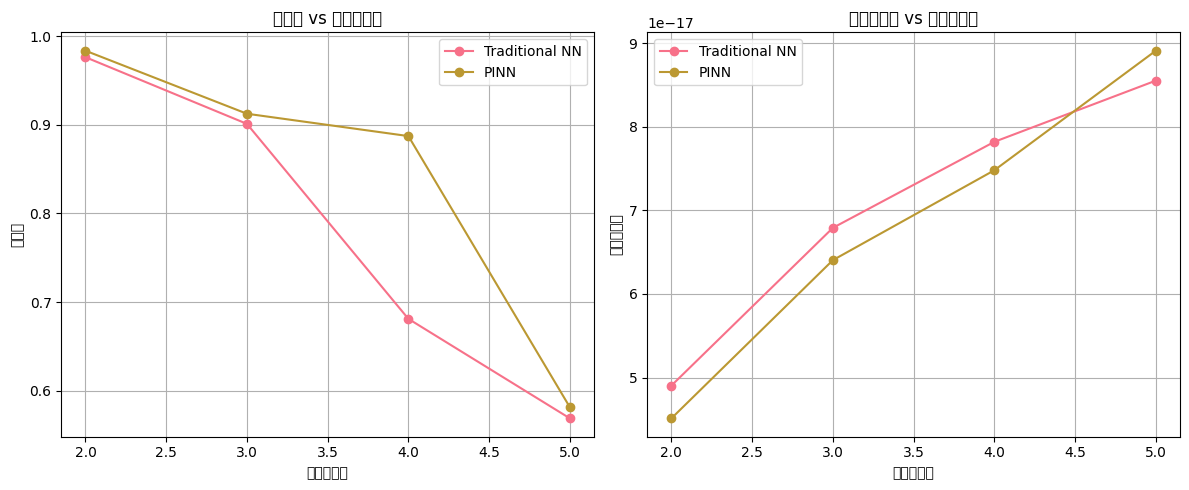


实验完成！


In [20]:
# 可视化可扩展性
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

for name in ['Traditional NN', 'PINN']:
    data = scalability_df[scalability_df['Model'] == name]
    axes[0].plot(data['Qubits'], data['Fidelity'], marker='o', label=name)
    axes[1].plot(data['Qubits'], data['Constraint_Violation'], marker='o', label=name)

axes[0].set_title('保真度 vs 量子比特数')
axes[0].set_xlabel('量子比特数')
axes[0].set_ylabel('保真度')
axes[0].legend()
axes[0].grid(True)

axes[1].set_title('约束违反度 vs 量子比特数')
axes[1].set_xlabel('量子比特数')
axes[1].set_ylabel('约束违反度')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

print("\n实验完成！")